### Data Misalignment Impact
---

In need of assessing performance impact of the data misalignment, let's assess some early performance result by looking at the performance of the 9/15 cohort. To be precise, we obtained production side features on 9/15, and obtained dev side target on 10/17, for the purpose of assesing the inital month hypothetical performance.

In [1]:
import sys, os, json
sys.path.append('../..')
import pandas as pd
import pickle as pkl
import lightgbm as lgb
from tqdm import tqdm
import src.monitoring.monitoring as mntr
from smart_open import open
import src.monitoring.utils as mu

import matplotlib.pyplot as plt
plt.style.use("seaborn")

%load_ext autoreload
%autoreload 2

In [2]:
s3_dir = "s3://sofi-data-science/jxu/data_dump/money_customer_risk/20210931-refitted-model-to-prod-v2/"
dev_df = pd.read_parquet(os.path.join(s3_dir, "dev-20210915-scored.parquet"))
prod_df = pd.read_parquet(os.path.join(s3_dir, "prod-20210915-scored.parquet"))
combined_df = pd.read_parquet(os.path.join(s3_dir, "dev-prod-scored-combined.parquet"))

<AxesSubplot:>

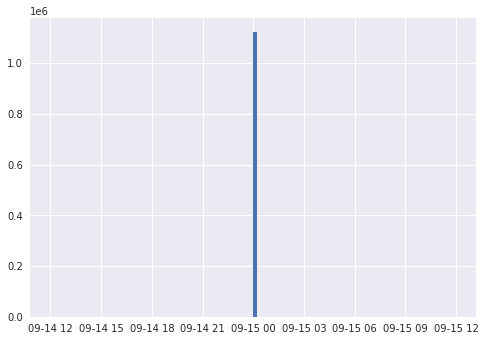

In [3]:
dev_1017 = pd.read_feather("../../data/combined_all_features/combined_1634529666.feather")
dev_1017 = dev_1017[dev_1017.sample_date==pd.to_datetime("2021-09-15")]
dev_1017.sample_date.hist(bins=100)

In [4]:
dev_1017.target.value_counts()

False    1117056
True        4770
Name: target, dtype: int64

In [5]:
dev_df.target.value_counts()

False    1116174
True        3472
Name: target, dtype: int64

In [6]:
dev_1017.business_account_number.nunique(), dev_df.business_account_number.nunique()

(1121826, 1119646)

In [7]:
df_ = dev_1017[["target", "business_account_number", "user_id"]]
df_.columns = ["target_1017", "business_account_number", "party_id"]

In [8]:
prod_df_ = prod_df.copy()
prod_df_ = pd.merge(prod_df, df_, on="party_id", how="left")

In [9]:
prod_df_["target_1017"].isna().value_counts()

False    1110090
True       20061
Name: target_1017, dtype: int64

In [10]:
prod_df_.columns

Index(['party_id', 'created_dt', 'updated_dt', 'last_checked_date',
       'last_checked_date_max', 'risk_group', 'request_source', 'model_score',
       'model_decision_rule_details', 'mcustomer_model_risk_groupodel_score',
       'proxy_id', 'risk_group_evaluation_method', 'partner_name',
       'first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score',
       'fraud_score_2', 'name_email_correlation',
       'transaction_as_pct_of_balance', 'mean_account_balance_30d',
       'giact_time_since_last_link', 'phone_risk_score',
       'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction',
       'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions',
       'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
       'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d',
       'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits',
       'time_since_last_transaction', 'bal_ratio', 'name_phone_correla

In [11]:
df_ = dev_1017[["target", "business_account_number", "user_id"]]
df_.columns = ["target_1017", "business_account_number", "user_id"]
combined_df = pd.merge(combined_df, df_, on="user_id", how="left")

In [12]:
combined_df.head()

,user_id,business_account_number_exp,score_prod_exp,score_prod_act,score_dev_exp,score_dev_act,incumbent_model_score_dev_exp,incumbent_model_score_dev_act,score_dev_data_prod_model,score_dev_data_dev_model,score_prod_data_prod_model,score_prod_data_dev_model,incumbent_model_dev_data,incumbent_model_prod_data,target_1017,business_account_number
0,305,410000276182,613.927501,616.901309,613.927501,616.901309,574.411334,573.720213,613.927501,613.927501,616.901309,616.901309,574.411334,573.720213,False,4.100003e+11
1,361,410000345005,476.012318,483.753944,476.012318,483.753944,478.306634,496.458316,476.012318,476.012318,483.753944,483.753944,478.306634,496.458316,False,4.100003e+11
2,637,410000300440,471.937248,445.956154,471.937248,445.956154,450.108314,444.716727,471.937248,471.937248,445.956154,445.956154,450.108314,444.716727,False,4.100003e+11
3,457,410011645378,543.099431,550.634507,543.099431,550.634507,503.178169,500.620276,543.099431,543.099431,550.634507,550.634507,503.178169,500.620276,False,4.100116e+11
4,468,410000331898,559.857236,559.977979,559.857236,559.977979,550.282359,525.433384,559.857236,559.857236,559.977979,559.977979,550.282359,525.433384,False,4.100003e+11


### prod vs prod

all users:  1110143


,auc,ap
incumbent_model_prod_data,66.53,8.46
score_prod_data_prod_model,74.70,19.92


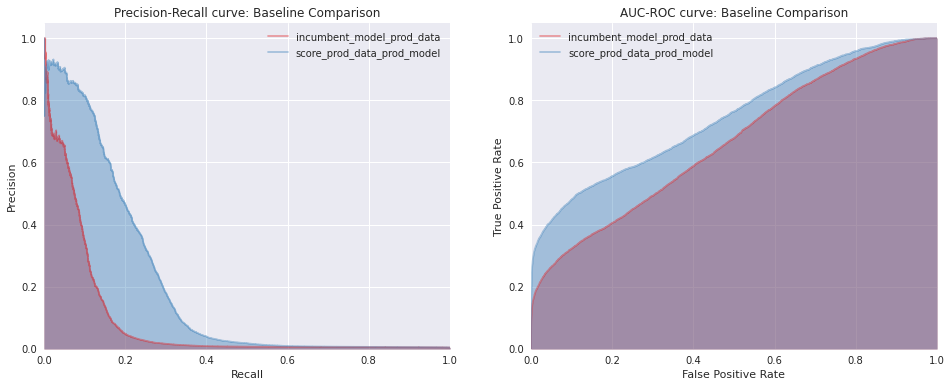

In [13]:
import src.monitoring.monitoring as mntr

combined_df = combined_df[~combined_df["target_1017"].isna()]
combined_df["target_1017"] = combined_df["target_1017"].astype(int)

pred_cols = ["incumbent_model_prod_data", "score_prod_data_prod_model"]
report = mntr.get_pred_reports(combined_df, "target_1017", pred_cols)

print("all users: ", combined_df.shape[0])
display(report[["auc", "ap"]])

mntr.save_valid_performance_plots(
        {"perf_1017": combined_df}, "target_1017", pred_cols, "/tmp/perf-plot.png", dropna=False
    )

In [14]:
active_accounts = dev_df[
        (dev_df.nr_past_transactions > 0) & (dev_df.nr_transactions_30d > 0)
    ].user_id.unique()
combined_df_active = combined_df[combined_df.user_id.isin(active_accounts)]

active users:  162108


,auc,ap
incumbent_model_prod_data,84.14,16.42
score_prod_data_prod_model,88.27,28.57


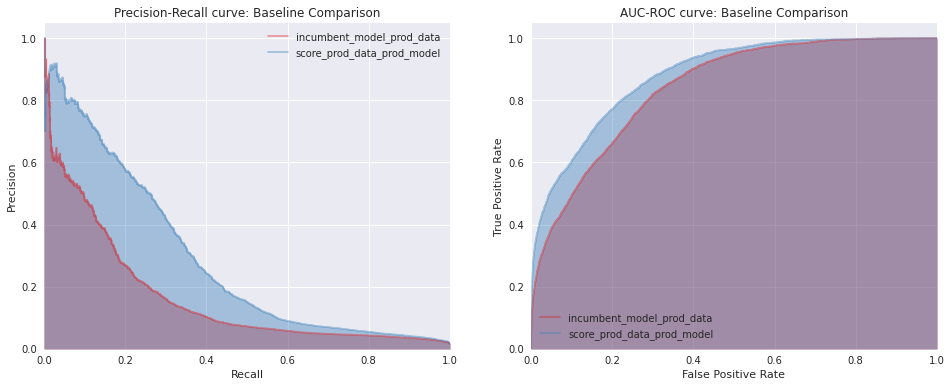

In [15]:
pred_cols = ["incumbent_model_prod_data", "score_prod_data_prod_model"]
report = mntr.get_pred_reports(combined_df_active, "target_1017", pred_cols)

print("active users: ", combined_df_active.shape[0])
display(report[["auc", "ap"]])

mntr.save_valid_performance_plots(
        {"perf_1017": combined_df_active}, "target_1017", pred_cols, "/tmp/perf-plot.png", dropna=False
    )

In [16]:
combined_df_active.shape, combined_df.shape

((162108, 16), (1110143, 16))

In [17]:
# mntr.get_segmented_performances(
#             {"": combined_df},
#             "target_1017",
#             ["incumbent_model_prod_data", "score_prod_data_prod_model"],
#             "./artifacts/incumbent-vs-refit-prod",
#             model_name="customer_risk",
#         )

# on vs fico adjusted - only valid fico
mntr.get_model_vs_baseline(
    combined_df,
    "target_1017",
    "score_prod_data_prod_model",
    "incumbent_model_prod_data",
     "./artifacts/incumbent-vs-refit-prod",
)

mntr.get_model_vs_baseline(
    combined_df_active,
    "target_1017",
    "score_prod_data_prod_model",
    "incumbent_model_prod_data",
     "./artifacts/incumbent-vs-refit-prod-active",
)

### dev vs prod

all users:  1110143


,auc,ap
score_dev_data_dev_model,71.24,15.36
score_prod_data_prod_model,74.70,19.92


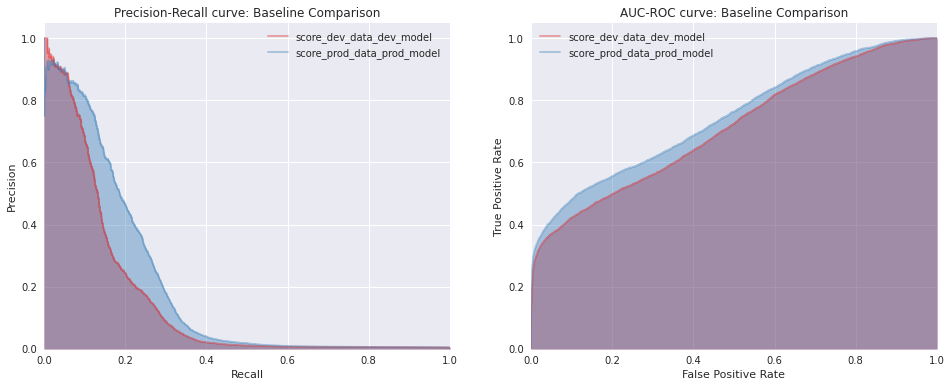

In [18]:
import src.monitoring.monitoring as mntr

combined_df = combined_df[~combined_df["target_1017"].isna()]
combined_df["target_1017"] = combined_df["target_1017"].astype(int)

pred_cols = ["score_dev_data_dev_model", "score_prod_data_prod_model"]
report = mntr.get_pred_reports(combined_df, "target_1017", pred_cols)

print("all users: ", combined_df.shape[0])
display(report[["auc", "ap"]])

mntr.save_valid_performance_plots(
        {"perf_1017": combined_df}, "target_1017", pred_cols, "/tmp/perf-plot.png", dropna=False
    )

active users:  162108


,auc,ap
score_dev_data_dev_model,87.73,29.61
score_prod_data_prod_model,88.27,28.57


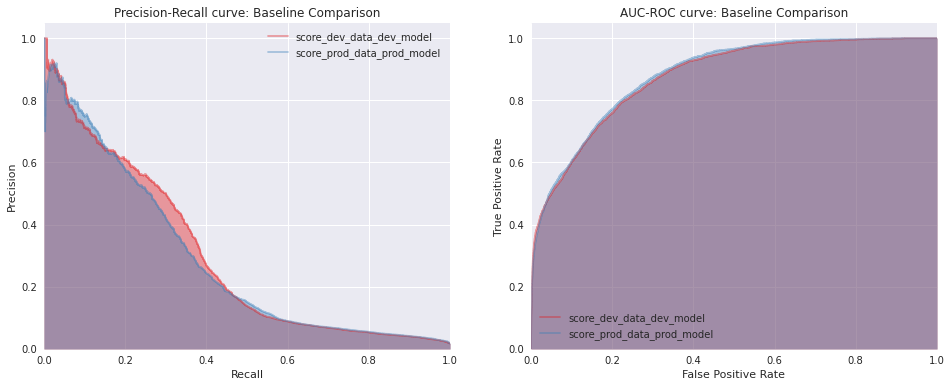

In [20]:
pred_cols = ["score_dev_data_dev_model", "score_prod_data_prod_model"]
report = mntr.get_pred_reports(combined_df_active, "target_1017", pred_cols)

print("active users: ", combined_df_active.shape[0])
display(report[["auc", "ap"]])

mntr.save_valid_performance_plots(
        {"perf_1017": combined_df_active}, "target_1017", pred_cols, "/tmp/perf-plot.png", dropna=False
    )

In [21]:
combined_df_active.shape, combined_df.shape

((162108, 16), (1110143, 16))

In [22]:
# mntr.get_segmented_performances(
#             {"": combined_df},
#             "target_1017",
#             ["incumbent_model_prod_data", "score_prod_data_prod_model"],
#             "./artifacts/incumbent-vs-refit-prod",
#             model_name="customer_risk",
#         )

# on vs fico adjusted - only valid fico
mntr.get_model_vs_baseline(
    combined_df,
    "target_1017",
    "score_prod_data_prod_model",
    "incumbent_model_prod_data",
     "./artifacts/incumbent-vs-refit-prod",
)

mntr.get_model_vs_baseline(
    combined_df_active,
    "target_1017",
    "score_prod_data_prod_model",
    "incumbent_model_prod_data",
     "./artifacts/incumbent-vs-refit-prod-active",
)

#### last check on distributions

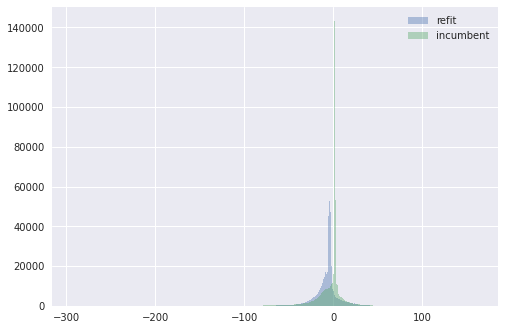

In [25]:
nbins = 1000
(combined_df.score_dev_data_dev_model - combined_df.score_prod_data_prod_model).hist(bins=nbins, alpha=0.4, label="refit")
(combined_df.incumbent_model_dev_data - combined_df.incumbent_model_prod_data).hist(bins=nbins, alpha=0.4, label="incumbent")
plt.legend()
plt.show()

### How does rg segmentations impact the performance within?
---

which RG should we consider as the "base"? 
* the current one>?

In [38]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

def get_risk_groups_refitted(serie):
    return pd.cut(serie.round(), [300, 520, 550, 570, 590, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

In [39]:
# often times oot > dev due to data diff
# rg segments

combined_df["rg_incumbent_model_prod_data"] = get_risk_groups(combined_df["incumbent_model_prod_data"])
combined_df["rg_dev_data_dev_model"] = get_risk_groups_refitted(combined_df["score_dev_data_dev_model"])
combined_df["rg_prod_data_prod_model"] = get_risk_groups_refitted(combined_df["score_prod_data_prod_model"])

In [41]:
rg_col = "rg_incumbent_model_prod_data"
pred_cols = ["incumbent_model_dev_data",
             "incumbent_model_prod_data",
             "score_dev_data_dev_model", 
             "score_prod_data_prod_model"]

for rg in ["RG1", "RG2", "RG3", "RG4", "RG5"]:
    df_ = combined_df[combined_df[rg_col]==rg]
    report = mntr.get_pred_reports(df_, "target_1017", pred_cols)
    display(rg)
    display(report)

'RG1'

,auc,ap,ks
incumbent_model_dev_data,74.09,0.40,40.35
incumbent_model_prod_data,73.70,0.15,41.49
score_dev_data_dev_model,81.73,1.01,51.67
score_prod_data_prod_model,81.23,1.05,51.90


'RG2'

,auc,ap,ks
incumbent_model_dev_data,51.89,0.92,7.45
incumbent_model_prod_data,54.58,0.17,9.15
score_dev_data_dev_model,68.01,1.67,29.43
score_prod_data_prod_model,68.11,0.50,29.00


'RG3'

,auc,ap,ks
incumbent_model_dev_data,54.55,1.02,9.75
incumbent_model_prod_data,52.66,0.27,5.46
score_dev_data_dev_model,69.79,2.31,31.57
score_prod_data_prod_model,69.20,1.12,28.96


'RG4'

,auc,ap,ks
incumbent_model_dev_data,54.46,1.01,9.85
incumbent_model_prod_data,53.85,0.40,7.54
score_dev_data_dev_model,70.41,2.33,31.21
score_prod_data_prod_model,70.09,3.18,28.57


'RG5'

,auc,ap,ks
incumbent_model_dev_data,58.63,12.23,22.58
incumbent_model_prod_data,64.38,11.35,27.15
score_dev_data_dev_model,69.65,20.39,39.87
score_prod_data_prod_model,76.98,26.64,46.37


#### send to arpit

In [30]:
cols = ["user_id", "business_account_number",
        "score_dev_data_dev_model", 
        "incumbent_model_prod_data", 
        "score_prod_data_prod_model",
        "target_1017",
        ]

data_path = "s3://sofi-data-science/jxu/data_dump/money_customer_risk/20210931-refitted-model-to-prod-v2/dev_prod_combined_w_tgt_1017.csv"
combined_df[cols].to_csv(data_path)